# Import Libraries

In [1]:
from src.capstone.evaluation import Evaluator
from src.capstone.cbf import CBF
from src.capstone.settings import Env

from bound_propagation.parallel import Parallel
from bound_propagation.bivariate import Mul
from bound_propagation.reshape import Select
from bound_propagation.polynomial import UnivariateMonomial
from bound_propagation.linear import FixedLinear
from bound_propagation.activation import Sin

import numpy as np
import gymnasium as gym
from gymnasium.spaces import Box

import torch
import torch.nn as nn

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator, RectBivariateSpline

# Gym wrapper for dynamics

In [2]:
class PendulumNoise(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(low=np.array([float('-inf'), -8]),
                                     high=np.array([float('inf'), 8]),
                                     dtype=np.float32)
        
        self.dt = 0.01
        
    def step(self, action):
        action = np.array([action], dtype=np.float32)  # cannot be scalar like used in Discrete gym envs
        
        th, thdot = self.env.unwrapped.state
        _, _, _, truncated, _ = self.env.step(action)
        
        u = np.clip(action, -self.env.unwrapped.max_torque, 
                    self.env.unwrapped.max_torque)[0]
        
        newthdot = thdot + np.sin(th) * self.dt + u * self.dt + np.random.normal(0., 0.025)
        newth = th + thdot * self.dt + np.random.normal(0., 0.005)
        
        self.env.unwrapped.state = np.array([newth, newthdot], dtype=np.float32)
        
        return self.env.unwrapped.state, 0., False, truncated, {}
    
    def reset(self, seed: list[float, float] = None):
        # allow the user to set the initial state directly, otherwise random state
        self.env.reset()
        
        if seed is not None:
            self.env.unwrapped.state = np.array(seed, dtype=np.float32)
        return self.env.unwrapped.state, {}

# NNDM

We assume the dynamics are known, to be able to directly compare our results to the paper. The NNDM outputs the EXPECTED next state (Gaussian noise term disappears).

In [3]:
class NNDM(nn.Sequential):
    # input [theta, theta_dot, u]
    
    def __init__(self):
        self.dt = 0.01
        
        super(NNDM, self).__init__(
            # outputs [theta{k+1}, theta{k}, theta_dot{k}, u{k}, sin() of previous 3 elements]
            Parallel(
                FixedLinear(
                    torch.tensor([
                        [1, self.dt, 0.]
                    ])
                ),
                
                Parallel(
                    FixedLinear(
                        torch.tensor([
                            [1., 0., 0.],
                            [0., 1., 0.],
                            [0., 0., 1.]
                        ])
                    ),
                    Sin(),
                )
            ),
            
            # now calculate theta_dot{k+1}, output [theta{k+1}, theta_dot{k+1}]
            Parallel(
                Select(0),
                FixedLinear(
                    torch.tensor([
                        [0., 0., 1., self.dt, self.dt, 0., 0.]
                    ])
                )
            )
        )

In [4]:
nndm = NNDM()

# Agent

In [5]:
class Agent(nn.Module):
    # dummy agent of linear form a = c1 * s1 + c2 * s2 + c3, always outputs 0.
    
    def __init__(self):
        super(Agent, self).__init__()
        
        self.layer = nn.Linear(2, 1)
        
        # dummy output of u=0
        self.layer.weight = nn.Parameter(torch.tensor([[0., 0.]]))
        self.layer.bias = nn.Parameter(torch.tensor([0.]))
    
    def forward(self, x):
        return self.layer(x)
    
    def select_action(self, x, exploration=False):
        if exploration:
            raise ValueError('This model is not implemented for exploration')
        else:
            return self.forward(x)

In [6]:
policy = Agent()

# Env settings

$$h(x) = 1 - \frac{6^2}{\pi^2} \left(\theta^2 + \dot{\theta}^2 + \frac{2}{\sqrt{3}} \theta \dot{\theta} \right)$$

In [7]:
class Pendulum(Env):
    def __init__(self):
        env = gym.make('Pendulum-v1')

        self.is_discrete = False
        
        self.settings = {
            'noise': [],
            'max_frames': 100
        }
        
        # h as defined in the paper
        self.h_function = nn.Sequential(
            Parallel(
                UnivariateMonomial([(0, 2)]),
                UnivariateMonomial([(1, 2)]),
                Mul(Select([0]), Select([1]))
            ),
            FixedLinear(
                torch.tensor([[1., 1., 2./(3.**0.5)]])
            ),
            FixedLinear(
                torch.tensor([[-36 / 3.1415**2]]),
                torch.tensor([1.])
            )
        )
        
        self.h_ids = [0, 1]
        self.std = [0.005, 0.025]
        self.env = PendulumNoise(env)

In [8]:
env = Pendulum()

# CBF

$$\nabla^2 h = \begin{bmatrix}
\frac{\partial^2{h}}{\partial{\theta}^2} & \frac{\partial^2{h}}{\partial{\theta}\partial{\dot{\theta}}}\\ 
\frac{\partial^2{h}}{\partial{\dot{\theta}}\partial{\theta}} & \frac{\partial^2{h}}{\partial{\dot{\theta}}^2}
\end{bmatrix}

= \begin{bmatrix}
-2 \cdot \frac{6^2}{\pi^2} & -\frac{2}{\sqrt{3}} \cdot \frac{6^2}{\pi^2}\\ 
-\frac{2}{\sqrt{3}} \cdot \frac{6^2}{\pi^2} & -2 \cdot \frac{6^2}{\pi^2}
\end{bmatrix}

= -2 \cdot \frac{6^2}{\pi^2} 
\begin{bmatrix}
1 & \frac{1}{\sqrt{3}}\\ 
\frac{1}{\sqrt{3}} & 1
\end{bmatrix}$$

Since the Hessian is a 2x2 matrix, the matrix 2-norm will be equal to the largest singular value. In this case we get

$$\nabla^2 h^T \ \nabla^2 h = 
4\cdot \frac{6^4}{\pi^4} 
\begin{bmatrix}
\frac{4}{3} & \frac{2}{\sqrt{3}}\\ 
\frac{2}{\sqrt{3}} & \frac{4}{3}
\end{bmatrix}

= \begin{bmatrix}
\frac{6912}{\pi^4} & \frac{3456 \sqrt{3}}{\pi^4}\\ 
\frac{3456 \sqrt{3}}{\pi^4} & \frac{6912}{\pi^4}
\end{bmatrix}$$

$$det(\nabla^2 h^T \ \nabla^2 h - \sigma I) =
\left( \frac{6912}{\pi^4} - \sigma \right)^2 - \frac{3456 \sqrt{3}}{\pi^4} ^ 2 = 0$$

$$\sigma_{\pm} = \frac{6912}{\pi^4} \pm \frac{3456 \sqrt{3}}{\pi^4}$$

So, finally we get (this output has been verified online to be correct):
$$\lambda_{max} = \sqrt{\sigma_+} = \frac{1}{\pi^2} \sqrt{6912 + 3456 \sqrt{3}}$$

$$cov(d) = \begin{bmatrix}
\sigma_1^2 & 0\\ 
0 & \sigma_2^2
\end{bmatrix}

= \begin{bmatrix}
0.005^2 & 0\\ 
0 & 0.025^2
\end{bmatrix}$$

$$tr(cov(d)) = 0.005^2 + 0.025^2 = 0.00065 = \frac{13}{20 000}$$

Now everything comes together
$$\psi = \frac{\lambda_{max}}{2} tr(cov(d))$$
$$\alpha = 1 - \psi = 1 - \frac{13}{40 000\pi^2} \sqrt{6912 + 3456 \sqrt{3}}$$

In [9]:
lambda_max = (1/3.1415**2) * (6912 + 3456 * 3 ** 0.5) ** 0.5
tr_cov = sum(noise ** 2 for noise in env.std)

alpha = 1 - (lambda_max / 2) * tr_cov
print(f'Alpha is {round(alpha, 3)}')

Alpha is 0.996


In [10]:
# what to do with delta? 
cbf = CBF(env, nndm, policy,
          alpha=[alpha],
          delta=[0.],
          no_action_partitions=2,
          no_noise_partitions=2,
          stochastic=False)

# Evaluation

In [11]:
evaluator = Evaluator(env, cbf)
f, h = evaluator.mc_simulate(policy, 10, seed=[0.1, 0.])

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
def p_u_experimental(xg, yg, num_agents=500):
    res = np.zeros([xg.shape[1], yg.shape[0]])

    x_y = np.dstack((xg, yg))
    gridpoints = [point for row in x_y for point in row]
    
    for idx, point in tqdm(enumerate(gridpoints)):
        end_frames, _ = evaluator.mc_simulate(policy, num_agents, cbf_enabled=True, seed=list(point), progress_bar=False)
        p_u = sum(f <= 100 for f in end_frames)/len(end_frames) if len(end_frames) > 0 else 0.
        
        i, j = idx % x_y.shape[1], idx // x_y.shape[0]
        res[i, j] = p_u
     
    # print(res)       
    return res

In [13]:
def state_space_plot(interp_resolution, num_agents=500):
    # define regions (left of the ellipse, ellipse and right of the ellipse)
    x_ellipse = np.linspace(-(3/2)**0.5 * np.pi/6 , (3/2)**0.5 * np.pi/6 , 1001)
    x_left = np.linspace(-0.75, -(3/2)**0.5 * np.pi/6, 101)
    x_right = np.linspace((3/2)**0.5 * np.pi/6, 0.75, 101)
    
    upper_ellipse = [-x/3**0.5 + (-2/3 * x**2 + np.pi**2 / 36)**0.5 for x in x_ellipse
                    if -(3/2)**0.5 * np.pi/6 <= x <= (3/2)**0.5 * np.pi/6]
    lower_ellipse = [-x/3**0.5 - (-2/3 * x**2 + np.pi**2 / 36)**0.5 for x in x_ellipse
                    if -(3/2)**0.5 * np.pi/6 <= x <= (3/2)**0.5 * np.pi/6]
    
    # points to evaluate simulation at
    x, y = np.linspace(-0.7, 0.7, 15), np.linspace(-0.7, 0.7, 15)
    xg, yg = np.meshgrid(x, y)
    
    data = p_u_experimental(xg, yg, num_agents)
    interp = RegularGridInterpolator((x, y), data, method='cubic')

    # points to interpolate at
    xx, yy = np.linspace(x_ellipse[0], x_ellipse[-1], interp_resolution), np.linspace(-0.7, 0.7, interp_resolution)
    X, Y  = np.meshgrid(xx, yy)
    
    fig, ax = plt.subplots()
    ax.scatter(X, Y, c=interp((X, Y)), cmap=plt.colormaps['coolwarm'])
    
    ax.plot(x_ellipse, upper_ellipse, color='black')
    ax.plot(x_ellipse, lower_ellipse, color='black')  
    
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\dot{\theta}$')
    
    # Plots the color map here, some size scaling that worked 
    ax.scatter(xg, yg, s=4, color='black', label=r'$\mathbf{x}_0$')
    ax.legend(loc=1)
    
    # shade outer regions
    outer_color = plt.colormaps['coolwarm'](1.)[:3]
    ax.fill_between(x_ellipse, 0.75, upper_ellipse, color=outer_color, alpha=1)
    ax.fill_between(x_ellipse, lower_ellipse, -0.75, color=outer_color, alpha=1)
    ax.fill_between(x_left, -0.75, 0.75, color=outer_color, alpha=1)
    ax.fill_between(x_right, -0.75, 0.75, color=outer_color, alpha=1)
    
    ax.set_xlim(-0.7, 0.7)
    ax.set_ylim(-0.7, 0.7)
    
    ax.set_title(r'Estimated $P_u$')
    
    plt.savefig("state_space_plot.png")
    plt.show()

225it [15:56,  4.25s/it]


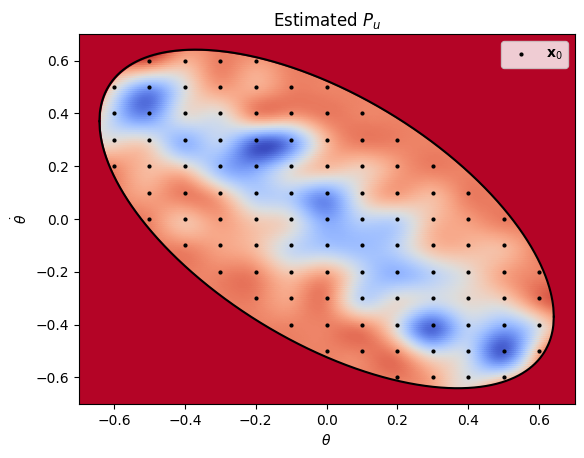

In [14]:
state_space_plot(200, 10)